# Figures

In [1]:
import os
import sys
import warnings
import numpy as np
import gudhi

import matplotlib
matplotlib.rcParams['text.usetex'] = False
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.colors import to_hex
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from shapely.geometry import Point
from itertools import combinations
from functools import reduce
from pathlib import Path
from gtda.mapper import (CubicalCover, Projection, make_mapper_pipeline, plot_static_mapper_graph)

warnings.filterwarnings('ignore')
sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname('src'), '..')))

from src.constants import *
from src.visualize import *
from src.data import *
from src.tda import TDA

np.random.seed(42)

## Empty Persistence Diagram

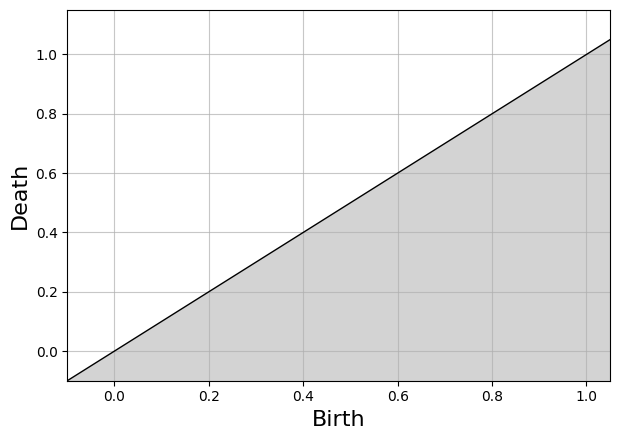

In [2]:
fig, ax = setup_figure(rows=1, cols=1)
gudhi.plot_persistence_diagram([], axes=ax)
plt.legend().remove()
plt.xlabel("Birth", fontsize=16)
plt.ylabel("Death", fontsize=16)
plt.grid(True, alpha=0.7)
plot(fig, '../figures/tda/empty_pd.svg')

## Persistence Diagram - Torus

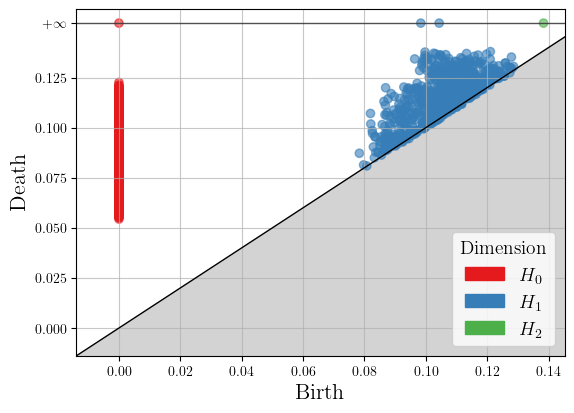

In [3]:
plot_persistence_diagram('../assets/torus.pers', fontsize=14, legend=True, title='', file=True, filename='../figures/tda/persistence_diagram_torus.svg')

## Barcode Plot - Torus

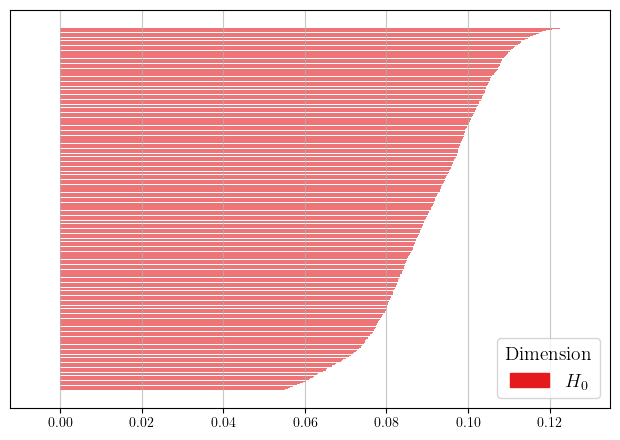

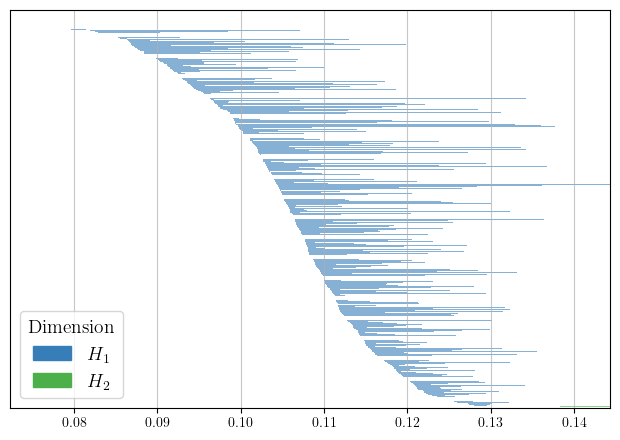

In [4]:
plot_barcode_diagram(np.loadtxt('../assets/torus.pers'), 
    title_0='', title_1_2='', fontsize=14, 
    filename_0='../figures/tda/torus_barcode_h0.svg', 
    filename_1_2='../figures/tda/torus_barcode_h1_h2.svg'
)

## Persistence Landscape - Torus

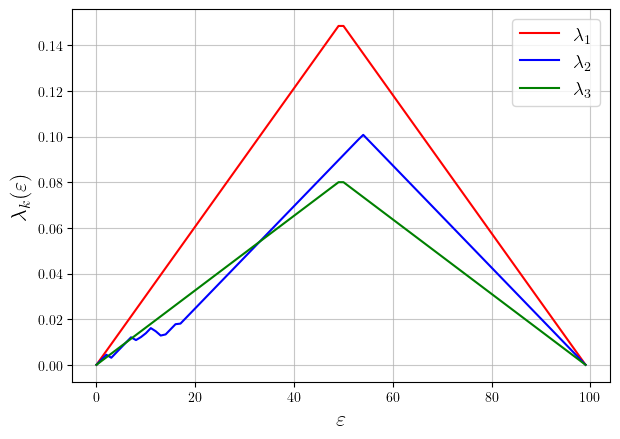

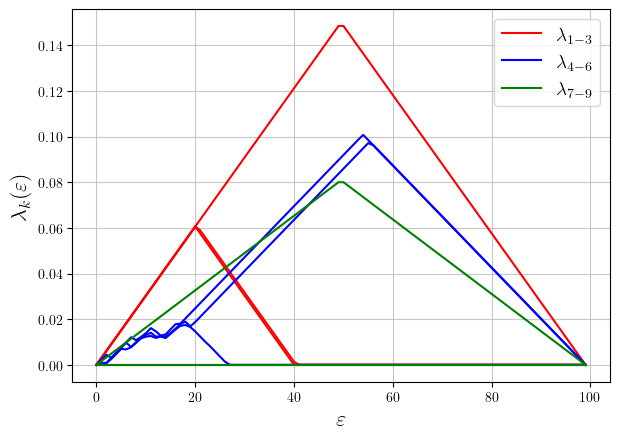

In [5]:
from gtda.diagrams import PersistenceLandscape

persistence_intervals = np.loadtxt('../assets/torus.pers')[:, [1, 2, 0]]
persistence_intervals[np.isinf(persistence_intervals)] = 0.3
persistence_intervals = np.expand_dims(persistence_intervals, axis=0)

plot_persistence_landscape(PersistenceLandscape(n_layers=1).fit_transform(persistence_intervals)[0], layers=1, title='', filename='../figures/tda/persistence_landscape_k1.svg')
plot_persistence_landscape(PersistenceLandscape(n_layers=3).fit_transform(persistence_intervals)[0], layers=3, title='', filename='../figures/tda/persistence_landscape_k3.svg')


## Persistence Image - Torus

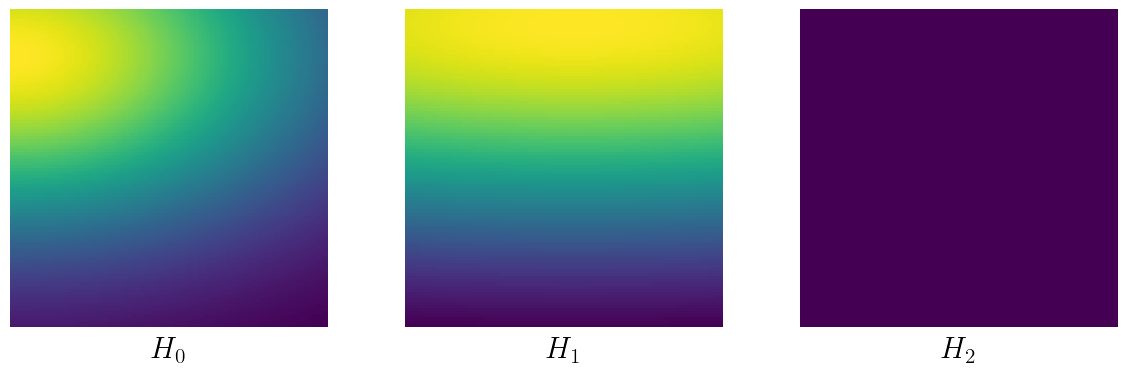

In [6]:
persistence_intervals = np.loadtxt('../assets/torus.pers')[:, [1, 2, 0]]
persistence_intervals[np.isinf(persistence_intervals)] = 0.3
persistence_intervals = np.expand_dims(persistence_intervals, axis=0)

TDA[PI][FUNCTION](persistence_intervals)
plot_persistence_image(TDA[PI][FUNCTION](persistence_intervals), title='', filename='../figures/tda/persistence_images.svg')

## Cech Complex

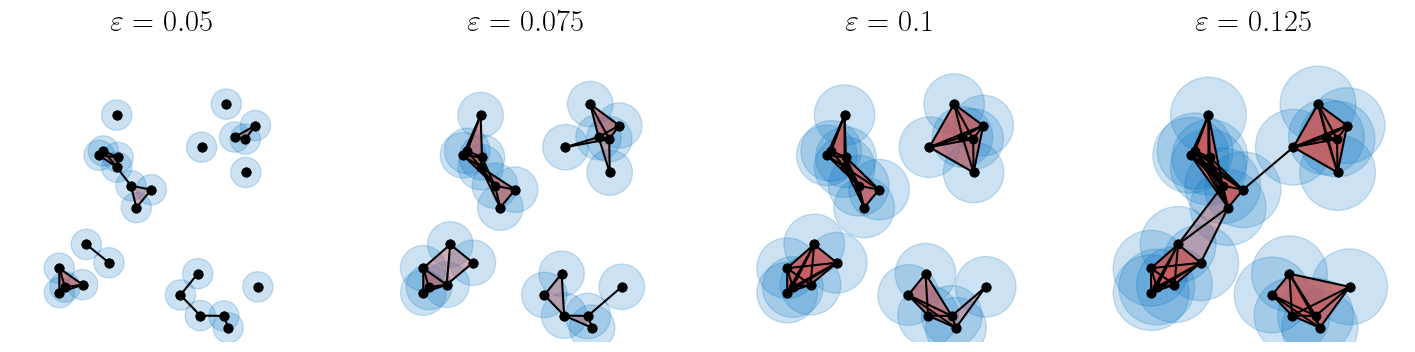

In [7]:
def generate_cluster(center, n=7, spread=0.08):
    return center + spread * np.random.randn(n, 2)

def balls_intersect(points, centers, epsilon):
    return not reduce(lambda a, b: a.intersection(b), [Point(centers[i]).buffer(epsilon) for i in points]).is_empty

def plot_cech_with_balls(points, epsilon, ax):
    ax.set_title(r'$\varepsilon = {}$'.format(epsilon), fontsize=22, fontweight='bold')
    ax.scatter(points[:, 0], points[:, 1], c='black', s=40)

    for p in points:
        ax.add_patch(plt.Circle(p, epsilon, color='#0070c0', alpha=0.2))

    for i in range(len(points)):
        ax.plot(*points[i], 'ko')

    for i, j in combinations(range(len(points)), 2):
        if np.linalg.norm(points[i] - points[j]) <= 2 * epsilon:
            if balls_intersect([i, j], points, epsilon):
                ax.plot(points[[i, j], 0], points[[i, j], 1], 'k-', linewidth=1.5)

    for i, j, k in combinations(range(len(points)), 3):
        if balls_intersect([i, j, k], points, epsilon):
            triangle = points[[i, j, k]]
            ax.fill(triangle[:, 0], triangle[:, 1], 'indianred', alpha=0.4)

    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

points = np.vstack([
    generate_cluster(np.array([0.2, 0.2]), 6),
    generate_cluster(np.array([0.7, 0.2]), 6),
    generate_cluster(np.array([0.4, 0.6]), 8),
    generate_cluster(np.array([0.75, 0.7]), 6)
])
epsilons = [0.05, 0.075, 0.1, 0.125]

fig, axs = plt.subplots(1, len(epsilons), figsize=(18, 5))
for i, eps in enumerate(epsilons):
    plot_cech_with_balls(points, eps, axs[i])

plt.show()
fig.savefig('../figures/tda/cech.svg', format='svg', bbox_inches='tight')

## Vietoris-Rips Complex

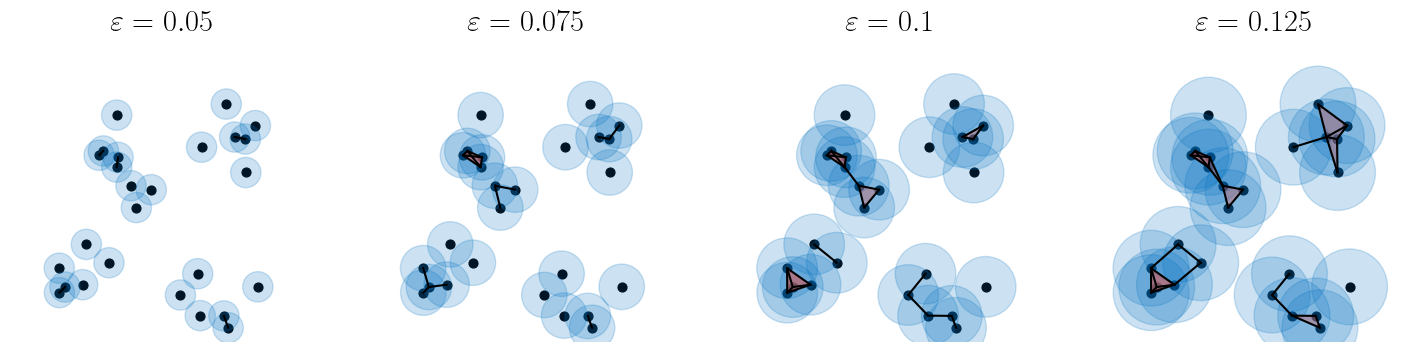

In [8]:
def plot_rips_with_balls(points, epsilon, ax):
    rips_complex = gudhi.RipsComplex(points=points, max_edge_length=epsilon)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=3)

    ax.set_title(r'$\varepsilon = {}$'.format(epsilon), fontsize=22, fontweight='bold')
    ax.scatter(points[:, 0], points[:, 1], c='black', s=40)

    for p in points:
        ax.add_patch(plt.Circle(p, epsilon, color='#0070c0', alpha=0.2))

    for simplex, filt in simplex_tree.get_simplices():
        if filt > epsilon:
            continue
        if len(simplex) == 2:
            ax.plot(points[simplex, 0], points[simplex, 1], 'k-', linewidth=1.5)
        elif len(simplex) == 3:
            triangle = points[simplex]
            ax.fill(triangle[:, 0], triangle[:, 1], 'indianred', alpha=0.4)

    ax.set_aspect('equal')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

fig, axs = plt.subplots(1, len(epsilons), figsize=(18, 5))
for i, eps in enumerate(epsilons):
    plot_rips_with_balls(points, eps, axs[i])
    
plt.show()
fig.savefig('../figures/tda/vietoris_rips.svg', format='svg', bbox_inches='tight')

## Mapper Algorithm

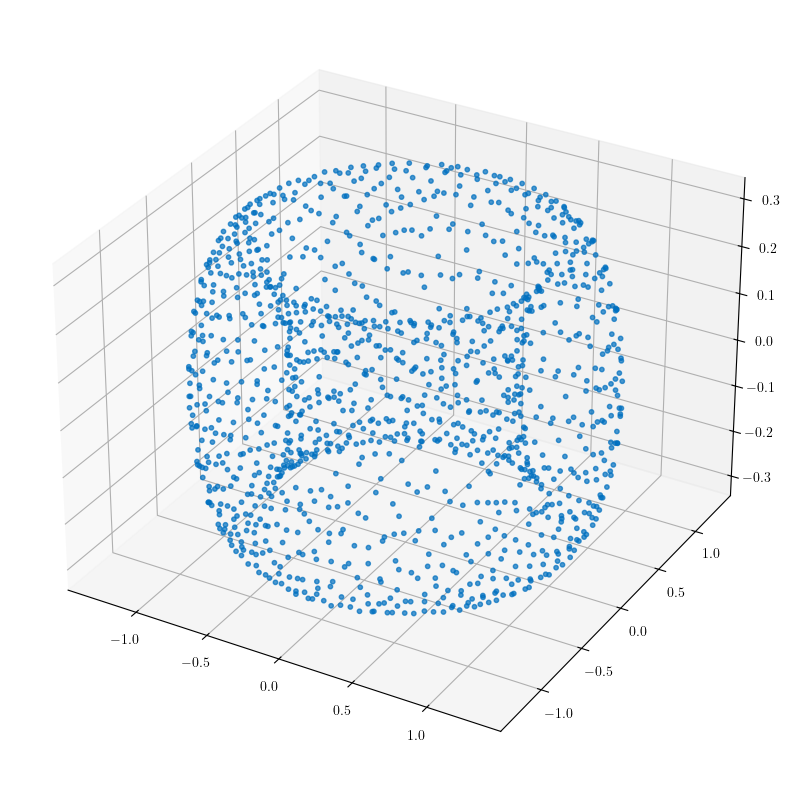

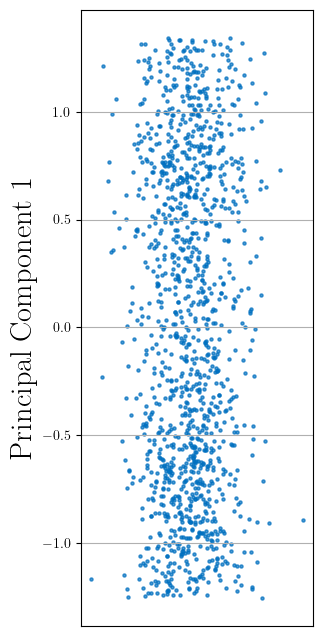

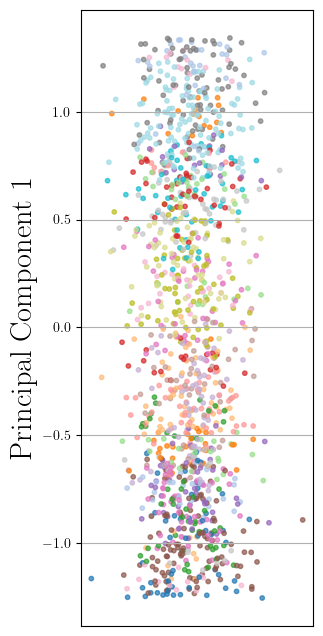

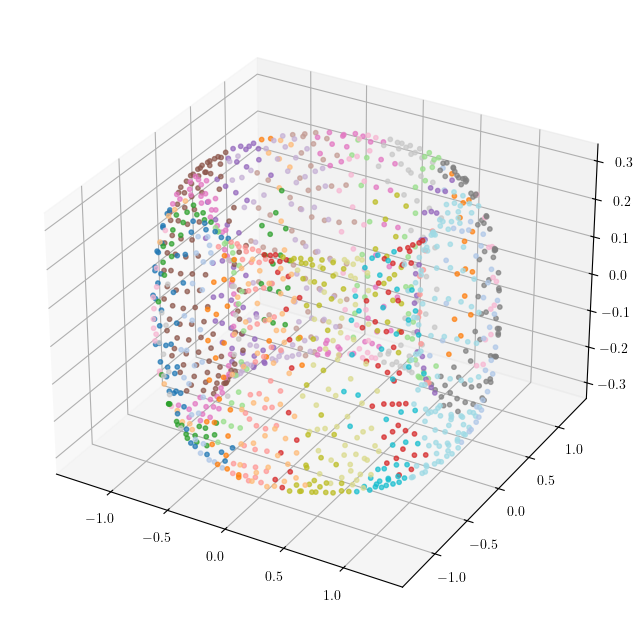

In [9]:
def load_off_file(filepath):
    with open(filepath, 'r') as f:
        if f.readline().strip() != 'OFF':
            raise ValueError('Not a valid OFF file.')
        n_verts, _, _ = map(int, f.readline().strip().split())
        verts = [list(map(float, f.readline().strip().split())) for _ in range(n_verts)]
    return np.array(verts)

data = load_off_file(Path('../assets/torus.off'))
fig = plt.figure(figsize=(8, 8), constrained_layout=True)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], s=10, c='#0070c0', alpha=0.7)
ax.set_title('')
plt.tight_layout()
plt.show()
fig.savefig('../figures/appendix/mapper_1.svg', format='svg', bbox_inches='tight')

pipe = make_mapper_pipeline(
    filter_func=Projection(columns=[0, 1]),
    cover=CubicalCover(n_intervals=10, overlap_frac=0.3),
    clusterer=DBSCAN(),
    verbose=False,
    n_jobs=N_JOBS
)

pca = PCA(n_components=1)
data_pca_1d = pca.fit_transform(data)
x_jitter = 0.01 * np.random.randn(len(data_pca_1d))

fig = plt.figure(figsize=(3, 8))
plt.scatter(x_jitter, data_pca_1d[:, 0], s=5, c='#0070c0', alpha=0.7)
plt.title('')
plt.ylabel('Principal Component 1', fontsize=22)
plt.xticks([])
plt.grid(True, axis='y')
plt.show()
fig.savefig('../figures/appendix/mapper_2.svg', format='svg', bbox_inches='tight')

graph = pipe.fit_transform(data)
memberships = np.full(len(data), -1)

for node_id, point_ids in enumerate(graph.vs['node_elements']):
    memberships[point_ids] = node_id

cmap = cm.get_cmap('tab20', np.max(memberships) + 1)

fig = plt.figure(figsize=(3, 8))
plt.scatter(x_jitter, data_pca_1d, s=10, c=cmap(memberships), alpha=0.7)
plt.title('')
plt.ylabel('Principal Component 1', fontsize=22)
plt.xticks([])
plt.grid(True, axis='y')
plt.show()
fig.savefig('../figures/appendix/mapper_3.svg', format='svg', bbox_inches='tight')

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=cmap(memberships), s=10, alpha=0.7)
ax.set_title('')
plt.show()
fig.savefig('../figures/appendix/mapper_4.svg', format='svg', bbox_inches='tight')

graph = pipe.fit_transform(data)
n_samples = data.shape[0]
memberships = np.full(n_samples, -1, dtype=int)
for node_id, sample_ids in enumerate(graph.vs['node_elements']):
    memberships[sample_ids] = node_id
n_nodes = np.max(memberships) + 1
cmap = cm.get_cmap('tab20', n_nodes)
node_colors_hex = [ to_hex(cmap(i)) for i in range(n_nodes) ]
plotly_params = {
    'node_trace': {
        'marker': {
            'color': node_colors_hex,
            'colorscale': None,
            'showscale': False,
        }
    },
    'edge_trace': {
        'line': {'color': 'lightgrey', 'width': 1}
    },
    'layout': {
        'title': '',
        'margin': {'l': 20, 'r': 20, 't': 40, 'b': 20},
    },
    'colorbar': {
        'thickness': 15,
        'xanchor': 'left',
        'title': {
            'text': '',
            'side': 'right'
        }
    }
}

fig = plot_static_mapper_graph(
    pipe,
    data,
    color_data=None,
    plotly_params=plotly_params
)
fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
fig.write_image('../figures/appendix/mapper_5.svg')